# Hyperbolic Embedding Methods for Medical Ontology Networks
<br>


**Drew Wilimitis** <br> 
Department of Biomedical Informatics, Vanderbilt University Medical Center

![title](images/three_models.png)

## Writing/Research Project Outline <br>

____

### Abstract :
<br>
 

### Intro: Broader Introduction and Contextual Framing  of My Investigation
<br>

As discussed in a recent survey of representation learning for Electronic Health Records **[1]**, there is currently a vast, disparate set of clinical data sources through which we attempt to understand a multi-layered, incredibly complex social network of patient-clinician interactions. In addition, the prevalence of high-throughput genomics data and cross-collaboration with clinical research is incredibly promising towards a more complete scientific understanding of biomedicine as it currently exists. However, to understand the dynamical processes involved in this system will significantly complicate the challenge of learning meaningful, informative data representations.
<br>
<br>

This problem of representation learning challenges the progression of biomedical informatics and clinical science not only in the potential to build less accurate predictive models, but also to potentially erode any human interpretation or explainability of these algorithms. Given that many SOTA methods for representation learning are highly sophisticated deep-learning algorithms, and also because these SOTA methods involve immensely expensive transfer learning, converging to potentially hundreds of millions of parameters like BERT, despite its undeniable success in NLP tasks.<br>

### 2. Background Overview of Hyperbolic Geometry:

<br>

**Note**: other datasets amenable to hyperbolic approaches: train a better and joint embedding with the hierarchy of medical ontologies, the textual descriptions of concepts, and even patients’ EHR data in the hyperbolic space

### 3.1-3.4: Hyperbolic Embeddings <br>

- Method 1: Apply the Poincare Embedding Algorithm

- Method 2: Apply Lorentz Embedding

- Method 3: Lorentzian Distance Learning??


### 4.  Evaluation (to Euclidean & Earlier Approach) <br>
<br>

### 5. Apply Hyperbolic KMeans/Clustering?<br>
<br>

### 6. Conclusion/Discussion <br>
<br>
<br>

___
### References: <br>


**[1]**. Weng, Wei-Hung and Peter Szolovits. “Representation Learning for Electronic Health Records.” ArXiv abs/1909.09248 (2019): n. pag.

Beaulieu-Jones, Brett & Kohane, Isaac & Beam, Andrew. (2019). Learning Contextual Hierarchical Structure of Medical Concepts with Poincairé Embeddings to Clarify Phenotypes. Pacific Symposium on Biocomputing. Pacific Symposium on Biocomputing. 24. 8-17. 

Cao, Jiazhen. “A Case Study for Predicting in-Hospital Mortality by Utilizing the Hyperbolic Embedding of ICD-9 Medical Ontology.” (2019).

Top FB AI poincare compare approaches with ICD: https://arxiv.org/pdf/1902.00913.pdf

Snomed2Vec and Poincaré Embeddings of a Clinical Knowledge Base for Healthcare Analytics: https://arxiv.org/pdf/1907.08650.pdf

gave public access to their results/embeddings/data: https://drive.google.com/drive/folders/1zre60Kd0nmQubgQO4iaf0TtWpVLaEKZO

Learning Electronic Health Records through Hyperbolic
Embedding of Medical Ontologies: https://dl.acm.org/doi/pdf/10.1145/3307339.3342148

independent ICD embedding resarcher: 
also came up with these embedding 3d visuals and provides his data sources:

http://projector.tensorflow.org/?config=https://raw.githubusercontent.com/aaronteoh/icd-embeddings/master/projector-config.json
https://tech.aaronteoh.com/medical-diagnosis-codes-embeddings/
https://raw.githubusercontent.com/aaronteoh/icd-embeddings/master/meta_desc.tsv
<br>

___

# Initial Data and Process Exploration 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import networkx as nx
import sys
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [2]:
all_codes = pd.read_csv('data/tmp/allcodes.csv', sep="|" , encoding='latin1', false_values=['"'])
majors = pd.read_csv('data/tmp/majors.csv', sep="|")
chapters = pd.read_csv('data/tmp/chapters.csv', sep="|").transpose()
sub_chapters = pd.read_csv('./data/tmp/subchapters.csv', sep="|").transpose()

df = pd.DataFrame(columns=['parent', 'child'])
# print(all_codes.head(3))

# handle chapters
chapters = chapters.reset_index()
chapters.columns = ['name', 'start', 'end']
chapters['range'] = 'c_' + chapters['start'].map(str) + '_' + chapters['end'].map(str)

chap_name_dict = dict(zip(chapters['name'], chapters['range']))
chap_range_dict = dict(zip(chapters['range'], chapters['name']))

sub_chapters = sub_chapters.reset_index()
sub_chapters.columns = ['name', 'start', 'end']
sub_chapters['range'] = 's_' + sub_chapters['start'].map(str) + '_' + sub_chapters['end'].map(str)

subchap_name_dict = dict(zip(sub_chapters['name'], sub_chapters['range']))
subchap_range_dict = dict(zip(sub_chapters['range'], sub_chapters['name']))

In [3]:
all_codes.head()

,code,billable,short_desc,long_desc,three_digit,major,sub_chapter,chapter
1,001,False,Cholera,Cholera,001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
2,0010,True,Cholera d/t vib cholerae,Cholera due to vibrio cholerae,001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
3,0011,True,Cholera d/t vib el tor,Cholera due to vibrio cholerae el tor,001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
4,0019,True,Cholera NOS,"Cholera, unspecified",001,Cholera,Intestinal Infectious Diseases,Infectious And Parasitic Diseases
5,002,False,Typhoid and paratyphoid fevers,Typhoid and paratyphoid fevers,002,Typhoid and paratyphoid fevers,Intestinal Infectious Diseases,Infectious And Parasitic Diseases


In [4]:
majors.head()
majors.shape

,x
Cholera,001
Typhoid and paratyphoid fevers,002
Other salmonella infections,003
Shigellosis,004
Other food poisoning (bacterial),005


(1234, 1)

In [5]:
chapters.head()
chapters.shape

,name,start,end,range
0,Infectious.And.Parasitic.Diseases,1,139,c_1_139
1,Neoplasms,140,239,c_140_239
2,Endocrine..Nutritional.And.Metabolic.Diseases....,240,279,c_240_279
3,Diseases.Of.The.Blood.And.Blood.Forming.Organs,280,289,c_280_289
4,Mental.Disorders,290,319,c_290_319


(19, 4)

In [6]:
sub_chapters.head()
sub_chapters.shape

,name,start,end,range
0,Intestinal.Infectious.Diseases,1,9,s_1_9
1,Tuberculosis,10,18,s_10_18
2,Zoonotic.Bacterial.Diseases,20,27,s_20_27
3,Other.Bacterial.Diseases,30,41,s_30_41
4,Human.Immunodeficiency.Virus..Hiv..Infection,42,42,s_42_42


(164, 4)

In [7]:
# filter letter codes for now
print(chapters.shape)
chapters = chapters[:17]
print(chapters.shape)

print(majors.shape)
majors = majors[:928]
print(majors.shape)

sub_chapters = sub_chapters[:119]

(19, 4)
(17, 4)
(1234, 1)
(928, 1)


In [8]:
relations = []
for i, major in majors.iterrows():
    # chapter first
    # then subchapter
    relations.append((major['x'], chapters.loc[(int(major['x']) >= chapters['start'].astype(int))
                                   & (int(major['x']) <= chapters['end'].astype(int))]['range'].values[0]))    
    sub_chapter_formajor = sub_chapters.loc[(int(major['x']) >= sub_chapters['start'].astype(int))
                                       & (int(major['x']) <= sub_chapters['end'].astype(int))]['range'].values
   
    if len(sub_chapter_formajor) == 1:
        relations.append((major['x'], sub_chapter_formajor[0]))
        

for i, sub in sub_chapters.iterrows():
    relations.append((sub['range'], chapters.loc[(int(sub['start']) >= chapters['start'].astype(int))
                                   & (int(sub['start']) <= chapters['end'].astype(int))]['range'].values[0]))

# why add these 'center' connections?
#for i, chapter in chapters.iterrows():
#    relations.append((chapter['range'], 'center'))

    
print(relations[-50:])
print(len(relations))

[('s_590_599', 'c_580_629'), ('s_600_608', 'c_580_629'), ('s_610_612', 'c_580_629'), ('s_614_616', 'c_580_629'), ('s_617_629', 'c_580_629'), ('s_630_633', 'c_630_679'), ('s_634_639', 'c_630_679'), ('s_640_649', 'c_630_679'), ('s_650_659', 'c_630_679'), ('s_660_669', 'c_630_679'), ('s_670_677', 'c_630_679'), ('s_678_679', 'c_630_679'), ('s_680_686', 'c_680_709'), ('s_690_698', 'c_680_709'), ('s_700_709', 'c_680_709'), ('s_710_719', 'c_710_739'), ('s_720_724', 'c_710_739'), ('s_725_729', 'c_710_739'), ('s_730_739', 'c_710_739'), ('s_760_763', 'c_760_779'), ('s_764_779', 'c_760_779'), ('s_780_789', 'c_780_799'), ('s_790_796', 'c_780_799'), ('s_797_799', 'c_780_799'), ('s_800_829', 'c_800_999'), ('s_800_804', 'c_800_999'), ('s_805_809', 'c_800_999'), ('s_810_819', 'c_800_999'), ('s_820_829', 'c_800_999'), ('s_830_839', 'c_800_999'), ('s_840_848', 'c_800_999'), ('s_850_854', 'c_800_999'), ('s_860_869', 'c_800_999'), ('s_870_897', 'c_800_999'), ('s_870_879', 'c_800_999'), ('s_880_887', 'c_80

In [9]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(relations)

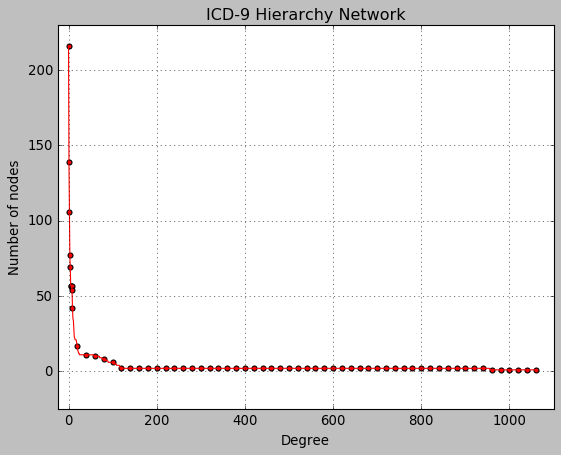

In [51]:
import collections
plt.style.use('classic')
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.figure() # you need to first do 'import pylab as plt'
plt.grid(True)
plt.plot(degree_sequence, 'r') # in-degree
node_ix = list(np.arange(0,10)) + list(np.arange(20, len(degree_sequence), 20))
plt.scatter(node_ix, np.array(degree_sequence)[node_ix], c='r')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('ICD-9 Hierarchy Network')
plt.ylim([-25, 230])
plt.xlim([-25, 1100])
plt.show();

In [52]:
# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(G)
# Average clustering coefficient
ccs = nx.clustering(G)
avg_clust = sum(ccs.values()) / len(ccs)
print('Avg Clustering Coefficient:', avg_clust)

Avg Clustering Coefficient: 0.8124787447825227


In [71]:
# get largest connected components in G
G_components = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
[len(c) for c in G_components]

[217, 140, 107, 78, 70, 58, 58, 58, 55, 43, 36, 35, 30, 24, 23, 21, 11]

In [78]:
component_graphs = [G.subgraph(c).copy() for c in G_components]
for cg in component_graphs:
    print(np.mean(list(nx.betweenness_centrality(cg).values())))

0.004581700980800755
0.007051253407212118
0.009187931917609223
0.012522565154144103
0.013920350748995251
0.01669043297899922
0.016701235848241295
0.016701235848241295
0.017571945873832664
0.02222942495205683
0.026844070961718022
0.027043544690603515
0.03119868637110016
0.038372859025032936
0.039713909279126665
0.047619047619047616
0.09090909090909091


In [ ]:
# Betweenness centrality
bet_cen = nx.betweenness_centrality(S[0])
# Closeness centrality
clo_cen = nx.closeness_centrality(S[0])

In [13]:
c = G_components[0]
C = G.subgraph(c).copy()
l1 = list(C.nodes())
#[k:v for k in subchap_range_dict.keys() list(c1.nodes())]
subchaps = set(l1).intersection(set(subchap_range_dict.keys()))
sub_labels = {k:subchap_range_dict[k] for k in subchaps}
chaps = set(l1).intersection(set(chap_range_dict.keys()))
chap_labels = {k:chap_range_dict[k] for k in chaps}

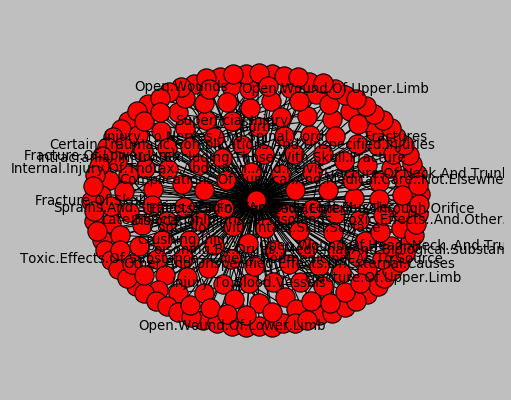

In [14]:
pos=nx.kamada_kawai_layout(C) # positions for all nodes

# nodes
nx.draw_networkx_nodes(C,pos)

# edges
nx.draw_networkx_edges(C,pos)

# labels
nx.draw_networkx_labels(C,pos,sub_labels,font_size=12)
plt.axis('off')
plt.show(); # display

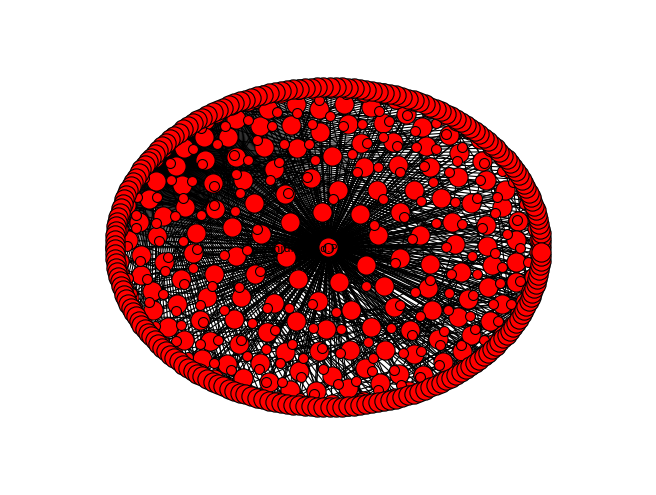

In [15]:
nx.draw_kamada_kawai(C)

nx.draw(C,labels=chap_labels, font_size=10, node_size=80)
nx.draw(C, pos=nx.shell_layout(C))

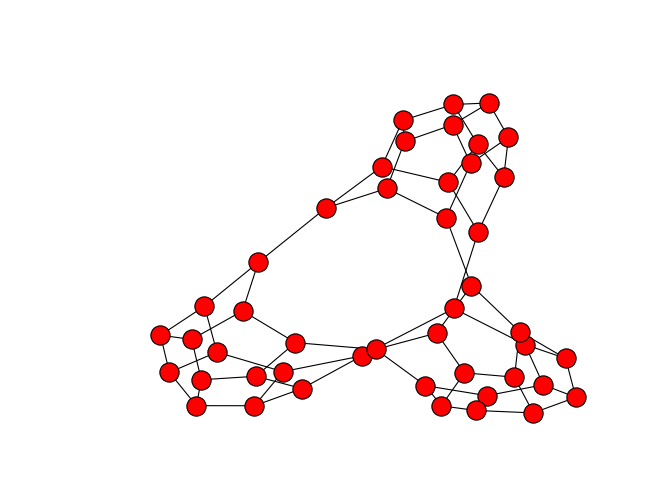

In [69]:
tutte=nx.tutte_graph()
nx.draw(tutte)

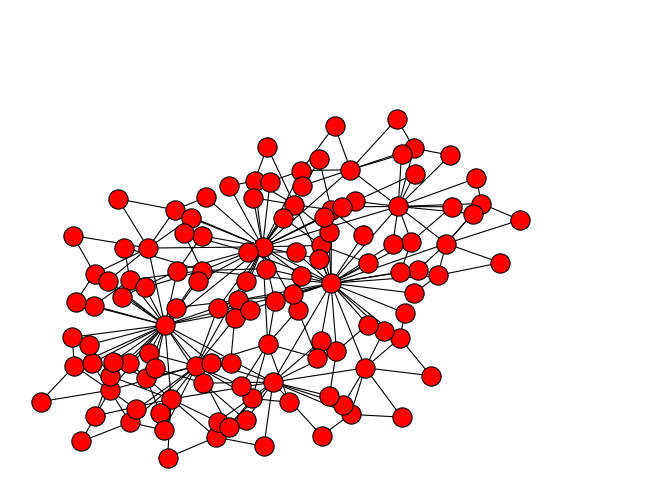

In [40]:
DGM = nx.dorogovtsev_goltsev_mendes_graph(5)
nx.draw(DGM)
#MK = nx.moebius_kantor_graph()
#nx.draw(MK)
nx.write_graphml(DGM, 'data/tmp/doro_mendes_graph')

In [30]:
import networkx as nx
import pydot
import matplotlib.pyplot as plt

try:
    from networkx import graphviz_layout
except ImportError:
    raise ImportError("This example needs Graphviz and either PyGraphviz or Pydot")


G=nx.balanced_tree(3,5)
pos=nx.graphviz_layout(G,prog='twopi',args='')
plt.figure(figsize=(8,8))
nx.draw(G,pos,node_size=20,alpha=0.5,node_color="blue", with_labels=False)
plt.axis('equal')
plt.savefig('circular_tree.png')
plt.show()

ImportError: This example needs Graphviz and either PyGraphviz or Pydot

In [90]:
# Betweenness centrality
bet_cen = nx.betweenness_centrality(S[0])
# Closeness centrality
clo_cen = nx.closeness_centrality(S[0])
# Eigenvector centrality
eig_cen = nx.eigenvector_centrality(S[0])

In [18]:
pd.read_csv('data/icd_data/icd.tsv', sep='\t', header=None, cols=[])

,0,1
0,001,c_1_139
1,001,s_1_9
2,002,c_1_139
3,002,s_1_9
4,003,c_1_139
...,...,...
1891,c_710_739,center
1892,c_740_759,center
1893,c_760_779,center
1894,c_780_799,center
